<h1><center><strong>Tarefas</strong></center></h1>

Notebook respondendo as tarefas propostas para a atividade:

**1.** Plotar gráficos dos preços e retornos e tecer comentários sobre possível
heterocedasticidade condicional;

**2.** Ajustar modelos de volatilidade univariados e escolher o mais adequado (pode usar
critérios de informação e/ou validação cruzada);


**3.** Prever a volatilidade um passo à frente usando o modelo selecionado no item anterior;


**4.** Comparar volatilidades entre os retornos selecionados (quais são maiores e menores,
relacionando com algum storytelling);


**5.** Calcular retorno do portfólio (usando pesos designados inicialmente) e ajustar um modelo
de volatilidade para o mesmo, realizando a previsão um passo à frente da volatilidade do
portfólio;


**6.** Calcular betas individuais usando regressão simples (estático) e tecer comentários;


**7.** Calcular beta estático de um portfolio contendo os ativos selecionados e pesos
determinados por vocês, assumindo as hipóteses do CAPM;


**8.** Fazer uma otimização dos pesos do seu portfólio inicial e repetir as etapas 5 e 7,
comparando o seu portfólio inicial com o otimizado. A otimização será abordada no lab.


### **Bibliotecas**

In [1]:
# Importando Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import ipywidgets as widgets
from IPython.display import display, clear_output
from arch import arch_model
from itertools import product

### **Dados**

Importando histórico de dados das empresas analisadas.

In [2]:
# Lista dos nomes dos arquivos CSV
arquivos = ['df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', 'df_USIM5', 'df_VALE3']

# Criando um dicionário onde a chave é o nome do arquivo e o valor é o DataFrame correspondente
dataframes = {nome: pd.read_csv(f"data\\{nome}.csv", parse_dates=True, index_col="Date") for nome in arquivos}

# Convertendo os índices de cada DataFrame para datetime com timezone UTC
for df in dataframes.values():
    df.index = pd.to_datetime(df.index, utc=True)

### **Gráficos e Funções**

Para manter o notebook mais claro e legível, todos os gráficos e funções serão criados nesta seção.

In [3]:
def plot_closing_prices(dataframes):
    # Configurando o tema escuro
    plt.style.use('dark_background')

    # Configurando o gráfico
    plt.figure(figsize=(10, 6))

    # Definindo uma lista de cores
    cores = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

    # Plotando cada série de dados com uma cor específica
    for (nome, df), cor in zip(dataframes.items(), cores):
        plt.plot(df['Close'], label=nome.split("_")[-1], color=cor)

    # Adicionando título e rótulos
    plt.title('Gráfico de Preços de Fechamento')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')

    # Mostrando a legenda à direita e fora do gráfico
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

    # Mostrar o gráfico
    plt.show()

In [4]:
def plot_closing_price(dataframes, acao_selecionada):
    # Configurando o tema escuro
    plt.style.use('dark_background')

    # Verifica se a ação selecionada está no dicionário de dataframes
    if acao_selecionada not in dataframes:
        print(f"Ação selecionada '{acao_selecionada}' não encontrada.")
        return

    # Configurando o gráfico
    plt.figure(figsize=(10, 6))

    # Plotando os dados da ação selecionada
    plt.plot(dataframes[acao_selecionada]['Close'], label=acao_selecionada.split("_")[-1], color='cyan')

    # Adicionando título e rótulos
    plt.title(f'Gráfico de Preço de Fechamento - {acao_selecionada.split("_")[-1]}')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento')

    # Mostrando a legenda
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))

    # Mostrar o gráfico
    plt.show()

In [5]:
def plot_closing_price_interactive(dataframes):
    # Configurando o tema escuro
    plt.style.use('dark_background')
    
    # Criação de um widget Dropdown para seleção da ação
    dropdown = widgets.Dropdown(
        options=list(dataframes.keys()),
        value=list(dataframes.keys())[0],
        description='Selecione a ação:',
        disabled=False,
    )
    
    # Criando dicionario de cor para cada ação
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Função para plotar o gráfico da ação selecionada
    def plot_graph(acao_selecionada):
        plt.figure(figsize=(10, 6))
        plt.plot(dataframes[acao_selecionada]['Close'], label=acao_selecionada.split("_")[-1], color=cores[acao_selecionada])
        plt.title(f'Gráfico de Preço de Fechamento - {acao_selecionada.split("_")[-1]}')
        plt.xlabel('Data')
        plt.ylabel('Preço de Fechamento')
        plt.legend(loc='upper left', bbox_to_anchor=(1,1))
        plt.show()
    
    # Chama plot_graph quando uma nova ação é selecionada
    def on_dropdown_change(change):
        clear_output(wait=True)
        display(dropdown)  # Redisplay dropdown para mantê-lo visível
        plot_graph(change['new'])
    
    # Observa mudanças no valor do dropdown
    dropdown.observe(on_dropdown_change, names='value')
    
    # Exibe o dropdown
    display(dropdown)
    # Exibe o gráfico inicial
    plot_graph(dropdown.value)


In [6]:
def plot_return(stock):
    # Limpa a figura atual
    plt.clf()
    # Criando a figura e os eixos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Definindo cores
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Plotando os logs de retornos
    dataframes[stock]["Log_Return"].plot(ax=ax1, color=cores[stock])
    ax1.set_title(f'Log Returns of {stock}')
    ax1.set_ylabel('Log Return')

    # Plotando a função de autocorrelação
    plot_acf(dataframes[stock]["Log_Return"].dropna(), ax=ax2, lags=50, color=cores[stock])
    ax2.set_title('Autocorrelation Function')

    plt.tight_layout()
    plt.show()


In [7]:
def plot_return_square(stock):
    # Limpa a figura atual
    plt.clf()
    # Criando a figura e os eixos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # Definindo cores
    cores = {
        "df_AZEV4": "blue",
        "df_ETER3": "green",
        "df_OPCT3": "red",
        "df_PETR4": "cyan",
        "df_USIM5": "magenta",
        "df_VALE3": "yellow" 
    }

    # Plotando os logs de retornos
    dataframes[stock]["Log_Return_square"].plot(ax=ax1, color=cores[stock])
    ax1.set_title(f'Log Returns of {stock}')
    ax1.set_ylabel('Log Return')

    # Plotando a função de autocorrelação
    plot_acf(dataframes[stock]["Log_Return_square"].dropna(), ax=ax2, lags=50, color=cores[stock])
    ax2.set_title('Autocorrelation Function')

    plt.tight_layout()
    plt.show()

### **Tarefas**

#### **1.** Plotar gráficos dos preços e retornos e tecer comentários sobre possível heterocedasticidade condicional;

Primeiramente plotando os gráficos de preços:

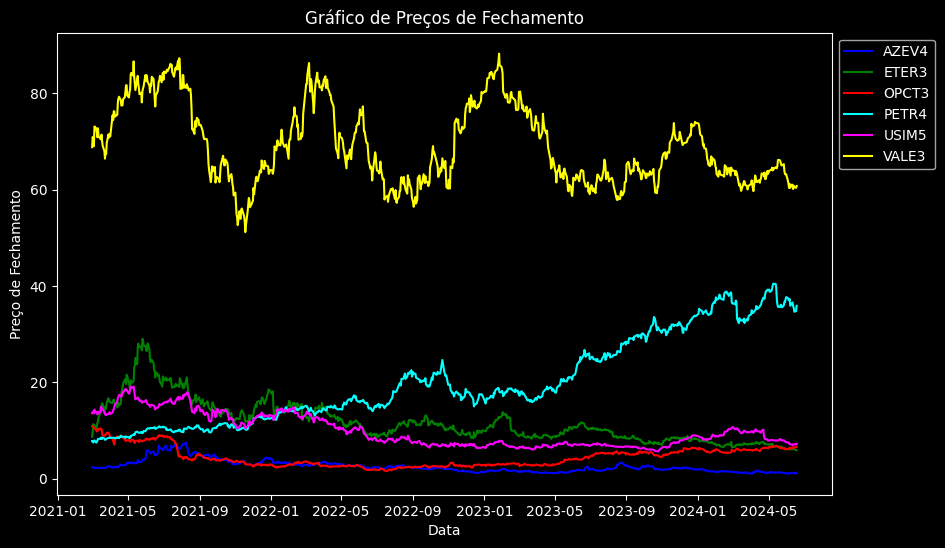

In [8]:
# Plotando Preços de Fechamento diários
plot_closing_prices(dataframes)

Como temos ações com diferentes faixas de preços, os preços também podem ser visualizados de acordo com cada tick no gráfico abaixo:

Dropdown(description='Selecione a ação:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', 'df_USIM5',…

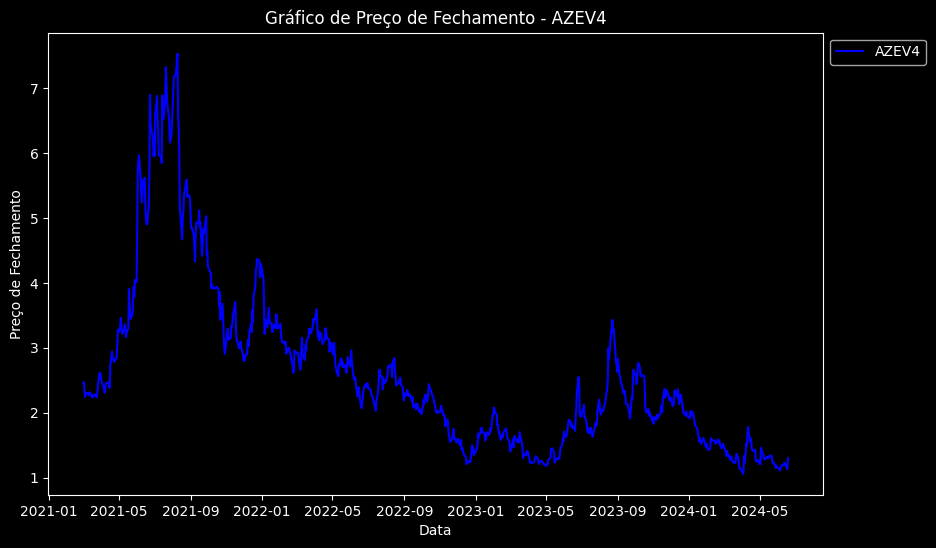

In [9]:
plot_closing_price_interactive(dataframes)

O próximo passo para esta primeira questão é calcular os logs dos retornos para cada uma das ações e plotar o gráfico para verificar o comportamento.

In [10]:
# Calculando os valores de log do retorno para cada um dos dataframes do dicionario dataframes
dfs_names_list = list(dataframes.keys())

for name in dfs_names_list:
    df_intermed = dataframes[name].copy()
    df_intermed["log_close"] = np.log(df_intermed["Close"])
    df_intermed["Log_Return"] = df_intermed["log_close"].diff().dropna()
    df_intermed.drop(columns=["log_close"], inplace=True)
    dataframes[name] = df_intermed

Com os logs retornos calculados, podemos plotar os gráficos abaixo:

In [11]:
# Widget para selecionar a ação
widgets.interact(plot_return, stock=widgets.Dropdown(options=dataframes.keys(), value='df_AZEV4', description='Stock:'))

interactive(children=(Dropdown(description='Stock:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', …

<function __main__.plot_return(stock)>

Observando os dois gráficos gerados para todos os ativos analisados, nota-se um comportamento muito similar ao de um ruído branco. Isso indica que o modelo nulo, como a média, pode ser suficiente para demonstrar o comportamento desses retornos, sugerindo, assim, uma falta de heterocedasticidade condicional.

Para contornar esta situação, podemos analisar o comportamento dos retornos ao quadrado e avaliar o comportamento neste caso.

In [12]:
# Calculando os valores de log do retorno para cada um dos dataframes do dicionario dataframes
dfs_names_list = list(dataframes.keys())

for name in dfs_names_list:
    df_intermed = dataframes[name].copy()
    df_intermed["Log_Return_square"] = df_intermed["Log_Return"] ** 2
    dataframes[name] = df_intermed

In [13]:
# Widget para selecionar a ação
widgets.interact(plot_return_square, stock=widgets.Dropdown(options=dataframes.keys(), value='df_AZEV4', description='Stock:'))

interactive(children=(Dropdown(description='Stock:', options=('df_AZEV4', 'df_ETER3', 'df_OPCT3', 'df_PETR4', …

<function __main__.plot_return_square(stock)>

**Questionar em aula**: Mesmo utilizando retornos ao quadrado, aparentemente não existe autocorrelação em nenhum lag da série.

#### **2.** Ajustar modelos de volatilidade univariados e escolher o mais adequado (pode usar critérios de informação e/ou validação cruzada);

Primeiramente será criado o grid de combinações de hiperparametros.

In [21]:
# Definindo os valores dos hiperparâmetros
p_values = range(1, 6)  # p de 1 a 6
q_values = range(1, 3)  # q de 1 a 3
dist_values = ['normal', 't']  # distribuições

# Gerando todas as combinações possíveis
combinations = list(product(p_values, q_values, dist_values))

# Criando a lista de dicionários
grid_params = [{'p': p, 'q': q, 'dist': dist} for p, q, dist in combinations]


grid_params

[{'p': 1, 'q': 1, 'dist': 'normal'},
 {'p': 1, 'q': 1, 'dist': 't'},
 {'p': 1, 'q': 2, 'dist': 'normal'},
 {'p': 1, 'q': 2, 'dist': 't'},
 {'p': 2, 'q': 1, 'dist': 'normal'},
 {'p': 2, 'q': 1, 'dist': 't'},
 {'p': 2, 'q': 2, 'dist': 'normal'},
 {'p': 2, 'q': 2, 'dist': 't'},
 {'p': 3, 'q': 1, 'dist': 'normal'},
 {'p': 3, 'q': 1, 'dist': 't'},
 {'p': 3, 'q': 2, 'dist': 'normal'},
 {'p': 3, 'q': 2, 'dist': 't'},
 {'p': 4, 'q': 1, 'dist': 'normal'},
 {'p': 4, 'q': 1, 'dist': 't'},
 {'p': 4, 'q': 2, 'dist': 'normal'},
 {'p': 4, 'q': 2, 'dist': 't'},
 {'p': 5, 'q': 1, 'dist': 'normal'},
 {'p': 5, 'q': 1, 'dist': 't'},
 {'p': 5, 'q': 2, 'dist': 'normal'},
 {'p': 5, 'q': 2, 'dist': 't'}]

Com o grid criado, podemos iterar para cada ativo analisado e encontrar a melhor combinação de hiperparametros.

In [24]:
resultados_final = []

for key in dataframes.keys():
    # Copiar o DataFrame original
    df_it = dataframes[key].copy()

    # Remover valores NaN e infinitos
    df_it = df_it[np.isfinite(df_it["Log_Return"])]

    results = []
    for i in range(0, len(grid_params)):
        # Ajustar o modelo GARCH
        garch = arch_model(df_it["Log_Return"], vol='Garch', p=grid_params[i]["p"], q=grid_params[i]["q"], dist=grid_params[i]["dist"], rescale=False)

        # Estimar o modelo
        model_fit = garch.fit(disp="off")

        # Adicionando aos resultados
        results.append({
            "AIC": model_fit.aic,
            "BIC": model_fit.bic,
            "params": grid_params[i]
        })
    
    # Transformando em dataframe
    results_df = pd.DataFrame(results)

    # Ordenando pela métrica AIC
    results_df = results_df.sort_values("AIC", ascending=False)

    # Adicionando aos resultados finais
    resultados_final.append({
        "Stock": key,
        "Best_AIC": results_df.iloc[0]["AIC"],
        "Best_BIC": results_df.iloc[0]["BIC"],
        "Best_param": results_df.iloc[0]["params"]
    })

    
# Exibindo os resultados
df_resultados_final = pd.DataFrame(resultados_final)

df_resultados_final

d:\Usuario\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Usuario\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
d:\Usuario\Documents\MeusProjetos\financial_analytics_final\f_a_f_env\lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Stock,Best_AIC,Best_BIC,Best_param
0,df_AZEV4,-2607.353000,-2564.936394,"{'p': 5, 'q': 2, 'dist': 'normal'}"
1,df_ETER3,-138.742630,-96.326024,"{'p': 5, 'q': 1, 'dist': 't'}"
2,df_OPCT3,-3142.215182,-3118.650401,"{'p': 2, 'q': 1, 'dist': 'normal'}"
3,df_PETR4,73599.487585,73623.052366,"{'p': 1, 'q': 1, 'dist': 't'}"
4,df_USIM5,-3693.466776,-3655.763127,"{'p': 5, 'q': 1, 'dist': 'normal'}"
5,df_VALE3,-3008.654298,-2980.376561,"{'p': 1, 'q': 2, 'dist': 't'}"


Com isso temos os melhores parametros para cada ativo. 

#### **3.** Prever a volatilidade um passo à frente usando o modelo selecionado no item anterior;